## General information about this notebook

This notebook series has been initiated by the Data Management Project (INF) within the TR-172 ["ArctiC Amplification: Climate Relevant Atmospheric and SurfaCe Processes, and Feedback Mechanisms" (AC)³](http://www.ac3-tr.de/) funded by the German Research Foundation (Deutsche Forschungsgemeinschaft, DFG)

Author(s) of this notebook: 
 - Mchedlishvili, Alexander, [*Institute of Environmental Physics, University of Bremen*](*https://www.iup.uni-bremen.de/deu/*), *Otto-Hahn-Allee 1, 28359 Bremen*, *alexander.mchedlishvili@uni-bremen.de*

Github repository: https://github.com/ac3-tr/ac3-notebooks

This notebook is licensed under the [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/ "CC-BY-4.0")

# Dataset description

**Title: Gridded pan-Arctic total neutral atmospheric 10-m drag coefficient estimates derived from ICESat-2 ATL07 sea ice height dat**     

**Authors: Mchedlishvili, Alexander$^1$; Lüpkes, Christof$^2$; Petty, Alek$^{3,4}$; Tsamados, Michel$^5$; Spreen, Gunnar$^1$**       

**$^1$Institute of Environmental Physics, University of Bremen, Bremen, Germany,** \
**$^2$Alfred Wegener Institute for Polar and Marine Research, Bremerhaven, Germany,** \
**$^3$Goddard Space Flight Center, National Aeronautics and Space Administration, Greenbelt, MD, USA,** \
**$^4$University of Maryland, College Park, MD, USA,** \
**$^5$Department of Earth Sciences, University College London, London, UK**

**Year: 023** 

**Description:** \
This data-set contains average drag coefficient estimates for the whole of the Arctic (resampled onto a 25 km polar stereographic grid) for each month from 11.2018 to 06.2022. The total drag coefficients are referenced to a height of 10 meters and a neutrally stratified atmosphere is assumed. The total drag is the sum of open water drag scaled with (1-A) where A is sea ice concentration [(Spreen et al., 2008)](https://doi.org/10.1029/2005JC003384), drag due to floe edges incorporated via a constant derived from parameterization [(Lüpkes et al., 2012)](https://doi.org/10.1029/2012JD017630) and scaled with A(1-A), sea ice skin drag scaled with A, and sea ice form drag due to obstacles (e.g. ridges) computed from sea ice feature averages [(Garbrecht et al., 2002)](https://doi.org/10.3402/tellusa.v54i2.12129) derived from ICESat-2 ATL07 sea ice heights (for all 25 km grid cells filled by ICESat-2 ATL07 data) [(Kwok et al., 2021)](https://doi.org/10.5067/ATLAS/ATL07.005). Each individual component is also given as a separate variable in the data-set. In addition, the sea ice feature averages (10-km average obstacle height and obstacle spacing) used to derive form drag due to obstacles is also gridded and included in the data files. Obstacles below a threshold value of 20 cm and those that do not fulfill the Rayleigh Criterion (wherein if the trough between two peaks is smaller than the higher of two crests, only the higher one is considered) are omitted. Lastly, we scale up the ICESat-2 ATL07-derived form drag coefficients via a regression derived from comparing them to drag coefficients derived from topographic data collected during the 04.2019 NASA airborne Operation IceBridge ICESat-2 under-flights [(Studinger, 2013)](https://doi.org/10.5067/19SIM5TXKPGT). This is to deal with the sampling issues associated with resolution differences.

**https://doi.pangaea.de/10.1594/PANGAEA.959728**        

**License:** [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/ "CC-BY-4.0")

## Contents of this notebook

This notebook is meant to allow users to map neutral 10-m obstacle form drag coefficients that are calculated with the [Garbrecht et al., (2002)](https://doi.org/10.3402/tellusa.v54i2.12129) parameterization from ICESat-2 ATL07 tracks.


## Import relevant modules

*__ make sure to only import absolutely necessary modules and use standard ones wherever possible __*
*__ standard modules are e.g. matplotlib, numpy, scipy, xarray, cartopy __*

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import numpy as np
from glob import glob

## Pre-processing of the imported data

The monthly pan-Arctic drag coefficient NetCDF4 files require no preprocessing as the drag coefficients are already calculated from ICESat-2 ATL07 topography data and the data is gridded and ready to be mapped via cartopy.

### Input Parameters

In [68]:
fpath = '/mnt/spaces/Altimeters/ICESat-2/Processed_Files/All_3_beams/0.2mThresh_201904_10km_segment_TotalDC_modOIB.nc' #file path
param = 'drag_TOT' #parameter name

### Data Extraction

In [69]:
ds = nc.Dataset(file) #load in NetCDF4 data file
dtypes=['drag_IS2', 'drag_ow', 'drag_fe', 'drag_o', 'drag_s', 'drag_TOT', 'data_dist', 'H_e', 'x_e'] #All contained parameter names other than lon and lat
assert param in dtypes #Make sure chosen param is listed in dtypes

data = np.array(ds[param][:]) #Convert param into an array
grid_lon = np.array(ds["lon"][:]) #Convert lon into an array
grid_lat = np.array(ds["lat"][:]) #Convert lat into an array
    
'''
Below are some conditional statements which match the parameter chosen with the reccomended colorbar limits.
In addition, drag coefficients are mutliplied by 1000 for easy reading. 
Lastly, correct colorbar labels are assigned.
'''
if param == 'drag_TOT':
    cbar_lims = [0.838,2.4]
    data *= 1000
    cbar_label = 'drag coeffient [10$^{-3}$]'
elif param == 'H_e':
    cbar_lims = [0.2, 0.8]
    cbar_label = 'ridge height [m]'
elif param == 'x_e':
    cbar_lims = [100, 600]
    cbar_label = 'ridge spacing [m]'
elif param == 'data_dist':
    cbar_lims = [0,5000]
    cbar_label = 'data distribution [segments/grid cell]'
else:
    cbar_lims = [0,1]
    data *= 1000
    cbar_label = 'drag coeffient [10$^{-3}$]'

### Plotting

In [70]:
def get_NSIDC(hemis,res,return_projection=False):
    """
    generate NSIDC lon/lat coordinates
    input:
        hemis: either "N" or "S"
        res: resolution, typically 3.125, 6.25, 12.5, 25 or 50
    output:
        lon, lat: arrays
    """
    assert hemis in ["N","S"]
    if hemis=="N":
        Projection=Proj(CRS.from_epsg(3413)) 
        x,y=np.mgrid[-5350+res/2:5850:res,
                     -3850+res/2:3750:res]*1000
    else:
        Projection=Proj(CRS.from_epsg(3976)) 
        x,y=np.mgrid[-3950+res/2:4350:res,
                     -3950+res/2:3950:res]*1000

    lon,lat=Projection(y,x,inverse=True)
    if return_projection:
        return lon,lat,Projection
    return lon,lat

def main():
    import matplotlib.pyplot as plt
    
    lon, lat = get_NSIDC('N',25)
    print(f'{lon.shape[0]} rows and {lon.shape[1]} columns')
    plt.matshow(lon)
    plt.show()
    plt.matshow(lat)
    plt.show()
    return lon, lat

if __name__ == '__main__':
    lon,lat = main()

NameError: name 'Proj' is not defined

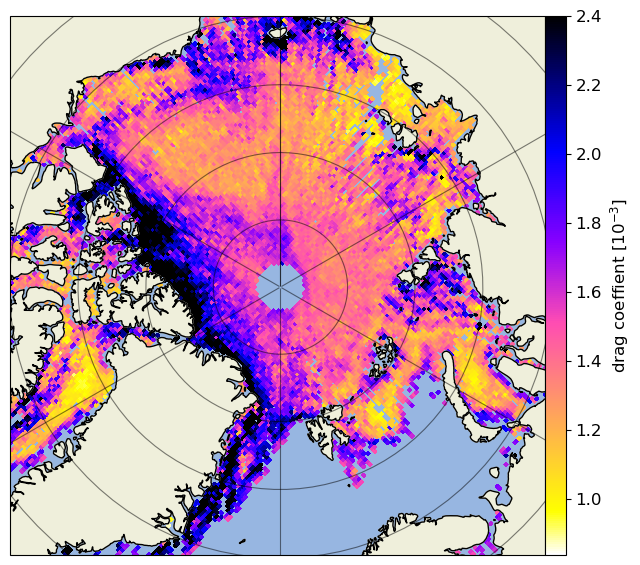

In [72]:
fig = plt.figure(figsize=(7,7)) #Define an empty figure of a given size
ax = fig.add_subplot(1,1,1,projection=ccrs.NorthPolarStereo()) #Add a subplot that is centered within the figure with the northern polar stereographic projection
ax.set_extent([-180,180,90,70], ccrs.PlateCarree()) #Set extent 
ax.add_feature(cfeature.OCEAN) #Add ocean layer
topo_plot = ax.pcolormesh(grid_lon, grid_lat, data, cmap = cmap, shading='flat', transform=ccrs.PlateCarree()) #Generate topography data (e.g. drag coeff., ridge heights, ridge spacings, etc.) plot
ax.add_feature(cfeature.LAND, zorder=2) #Add land layer
ax.coastlines(zorder=3) #Add coastlines 
ax.gridlines(color='black', alpha=0.5, zorder=4) #Add gridlines

'''
Below is the code responsible for aligning the colorbar with the plot.
'''
axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x1,axpos.y0,0.03,axpos.height])
cbar = fig.colorbar(topo_plot, cax=cbar_ax)
cbar.mappable.set_clim(cbar_lims[0],cbar_lims[1])
cbar.ax.tick_params(labelsize=12)
cbar.set_label(cbar_label, fontsize=12) 